In [1]:

from misc import plot_reward


import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import pickle


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('MountainCarContinuous-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Turn interactive mode on.
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cuda for simulation.


In [2]:
class Actor_Network(nn.Module):
    '''Actor network
    Inputs are ints of size'''
    def __init__(self, state, action,hidden1=600, hidden2=300):
        super(Actor_Network, self).__init__()
        self.FCL1 = nn.Linear(state,hidden1)
        self.FCL2 = nn.Linear(hidden1,hidden2)
        self.FCL3 = nn.Linear(hidden2,action)

    def reset_parameters(self):
        self.FCL2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.FCL3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, x):
        '''input states, return action'''
        x = F.relu(self.FCL1(x))
        x = F.relu(self.FCL2(x))
        x = torch.tanh(self.FCL3(x))
        return x
    
class Critic_Network(nn.Module):
    '''A Deep Q network for predicting actions given states'''
    def __init__(self, state, action, hidden1=600, hidden2=300):
        super(Critic_Network, self).__init__()
        self.FCL1 = nn.Linear(state,hidden1)
        self.FCL2 = nn.Linear(hidden1+action, hidden2)
        self.FCL3 = nn.Linear(hidden2,1)
    
    def reset_parameters(self):
        self.FCL2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.FCL3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        '''input stateaction, output value'''
        x = F.relu(self.FCL1(state))
        x = self.FCL2(torch.cat([x,action],dim=1))
        x = F.relu(x)
        x = self.FCL3(x)
        return x

In [3]:
'''A mapping of state-action pairs to next-state reward results'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'isDone'))


class ReplayMemory(object):
    '''a cyclic buffer of bounded size that holds recently observed transitions.'''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            # if we are at less than capacity, allocate fresh space for the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''Randomly return a batch of batch_size from the memory'''
        return random.sample(self.memory, batch_size)
    
    def get_item(self, memloc):
        '''Show Transition stored at memloc'''
        return self.memory[memloc]
    
    def clear(self):
        self.memory = []
        self.position = 0

    def __len__(self):
        
        return len(self.memory)
    
    def save(self):
        file = open('replay_buffer.obj', 'wb')
        pickle.dump(self.memory, file)
        file.close()

    def load(self):
        try:
            filehandler = open('replay_buffer.obj', 'rb')
            self.memory = pickle.load(filehandler)
            self.position = len(self.buffer)
        except:
            print('there was no file to load')


In [4]:
def select_action(state, training=True):
    '''torch.tensor -> torch.tensor
    
    Chooses an epsilon-greedy action given an input state.
    
    state: State vector
    training: Apply epsilon (bool.)
    '''
    
    policy_actor_net.eval()
    if len(memory) < BATCH_SIZE:
        action = env.action_space.sample()
    else:
        action = policy_actor_net(state).detach()
        action = action.squeeze(0).cpu().numpy()
    #print (action)
    mynoise=rnoise.noise()
    if debug_noise:
        print(mynoise)
        print()
    action += training  * mynoise 
    
    #action = np.clip(action, -1.0, 1.0)
    return action

def soft_update(target, source, tau=0.001):
    """
    update target neural net parameters by:
        target = tau * source + (1 - tau) * target
    target: Target network
    source: source network
    tau: 0 < tau << 1 (float)
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )    
    
def optimize_model():
    '''
    None -> float,float
    
    Update the actor and critic networks via SGD.
    returns actor loss and critic loss.
    '''
    if len(memory) < BATCH_SIZE:
        #print("Warning: We do not have enough history in memory to optimize our network")
        return 0, 0
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch 
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    isDone_batch = torch.cat(batch.isDone)
    
    target_actor_net.eval()
    next_action_batch = target_actor_net(next_state_batch).detach()
    
    target_q = target_critic_net(next_state_batch, next_action_batch).detach()
    
    y_expected = reward_batch + isDone_batch*gamma*target_q
    y_predicted = policy_critic_net(state_batch, action_batch)

    # critic gradient
    critic_loss = nn.MSELoss()
    loss_critic = critic_loss(y_predicted, y_expected)
    critic_optimizer.zero_grad()
    loss_critic.backward()
    critic_optimizer.step()

    # actor gradient
    pred_a = policy_actor_net(state_batch)
    loss_actor = (-policy_critic_net(state_batch, pred_a)).mean()
    actor_optimizer.zero_grad()
    loss_actor.backward()
    actor_optimizer.step()
    
    soft_update(policy_actor_net, target_actor_net, tau=0.001)
    soft_update(policy_critic_net, target_critic_net, tau=0.001)
    
    return loss_actor.item(), loss_critic.item()   

In [5]:
import numpy as np 

class OUNoise:
    """docstring for OUNoise"""
    def __init__(self, action_dimension, mu=0, theta=1.6, sigma=0.4):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [11]:
def action_mean_variance(env,n=500000):
    '''
    aigym.env, int -> float, float
    
    Calculate mean and variance of observation space of an environment from n random actions. 
    '''
    
    meanvar_memory=ReplayMemory(n)
    
    while len(meanvar_memory) < n:
        observation=env.reset()
        done=False
        for t in count():
            action=env.action_space.sample()
            observation, _ , done, _ = env.step(action)
            meanvar_memory.push(torch.from_numpy(np.cast['float32'](observation)).unsqueeze(0), None, None, None, None)
            if done:
                break
        if len(meanvar_memory)>=n:
                states=meanvar_memory.sample(n)
                batch = Transition(*zip(*states))
                batch_states=torch.cat(batch.state)
                mean=batch_states.mean(0)
                variance=batch_states.std(dim=0)
                meanvar_memory.clear()
                return mean, variance

def normalize_state(input, mean, variance):
    '''
    torch.tensor, float, float -> torch.tensor
    Converts a state to zero mean and unit variance.
    
    Note: An epsilon of 0.0000001 is used in the divisor of 
    the denominator to prevent numerical issues.
    '''
    return (input-mean)/(variance+0.0000001).to(device)
    
def unnormalize_state(input, mean, variance):
    '''
    torch.tensor, float, float -> torch.tensor
    Converts a state from zero mean and unit variance back to the original values.
    '''    
    return (input*(variance+0.0000001))+mean

def plot_reward(reward_input, pngout=False, pngpath='ouput.png'):
    '''
    List -> matplotlib.plt

    pngout (bool):  Save reward as png file.
    pngpath (str):  Location to save png file.


    Show the reward per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,dpi=300) 
    durations_t = torch.tensor(reward_input, dtype=torch.float)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t)
    if pngout:
        plt.savefig(pngpath)
    else:
        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            display.clear_output(wait=True)
            
def epsilon_threshold (steps, EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 200):
    '''float -> float
    
    Return the probabilty of selecting exploration in a RL step.
    '''

    return EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps / EPS_DECAY)

In [15]:
'''
ToDo:

'''

# Get number of actions from gym action space
n_actions = 1
# Get length of state space from gym observation space
n_states = 2

# Create two actor networks
policy_actor_net = Actor_Network(n_states, n_actions).to(device)
target_actor_net = Actor_Network(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_actor_net.load_state_dict(policy_actor_net.state_dict())

# Create two critic networks
policy_critic_net = Critic_Network(n_states, n_actions).to(device)
target_critic_net = Critic_Network(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_critic_net.load_state_dict(policy_critic_net.state_dict())

target_actor_net.eval()
target_critic_net.eval()

# Initialise noise generator
rnoise=OUNoise(n_actions)

actor_optimizer = optim.Adam(policy_actor_net.parameters(),lr=0.0001)
critic_optimizer = optim.Adam(policy_critic_net.parameters(),lr=0.001, weight_decay=0.001)
# Initialise the memory object.
memory = ReplayMemory(1000000)
memory.clear()

# Calculate the state space mean and variance from 1/2 million random actions
state_mean, state_variance = action_mean_variance(env,50000)
state_mean = state_mean.to(device)
state_variance = state_variance.to(device)

steps_done = 0
episode_durations = []
reward_values = []
action_values=[]
frame_values=[]
env.close()



In [16]:
BATCH_SIZE = 512

gamma=0.99
epsilon_max = 50
epsilon_decay = 200
epsilon_min=1

plot=True
render=True

debug_action=False
debug_noise=False
debug_loss=False

In [17]:
num_episodes = 5000
for i_episode in range(num_episodes):
    state = torch.from_numpy(np.cast['float32'](env.reset())).unsqueeze(0).to(device)
    state= normalize_state(state, state_mean, state_variance)
    TotalReward=0
    aLoss = []
    cLoss = []
    epsilon=epsilon_threshold(i_episode, epsilon_max, epsilon_min, epsilon_decay)
    epsilon=epsilon_max
    dist_reward=0.0
    for t in count():
        action = select_action(state)
        if debug_action:
            print(action)
        next_state, reward, done, _ = env.step(action)

        #env.render()

        TotalReward+= reward
        action = torch.from_numpy(np.cast['float32'](action)).unsqueeze(0).to(device)
        next_state = torch.from_numpy(np.cast['float32'](next_state)).unsqueeze(0).to(device)
        next_state= normalize_state(next_state, state_mean, state_variance)
        reward = torch.tensor([reward], device=device,dtype=torch.float32).unsqueeze(0).to(device)

        if not done:
            # Use ints, not Bool. torch.cat doesn't like Bools.
            isDone = 0
        else:
            isDone = 1 
        isDone = torch.tensor([isDone], device=device,dtype=torch.float32).unsqueeze(0).to(device)
        memory.push(state, action, next_state, reward, isDone)
        
        state = next_state

        # Perform one step of the optimization
        actor_loss, critic_loss = optimize_model()
        aLoss.append(actor_loss)
        cLoss.append(critic_loss)
        
        if debug_loss:
            print (actor_loss, critic_loss)
        
        if done:
            episode_durations.append(t + 1)
            reward_values.append(TotalReward)
            if plot:
                plot_reward(reward_values)
            break
        
#env.render()
env.close()
#plt.ioff()
#plt.show()
if plot:
    plot_reward(reward_values)

KeyboardInterrupt: 

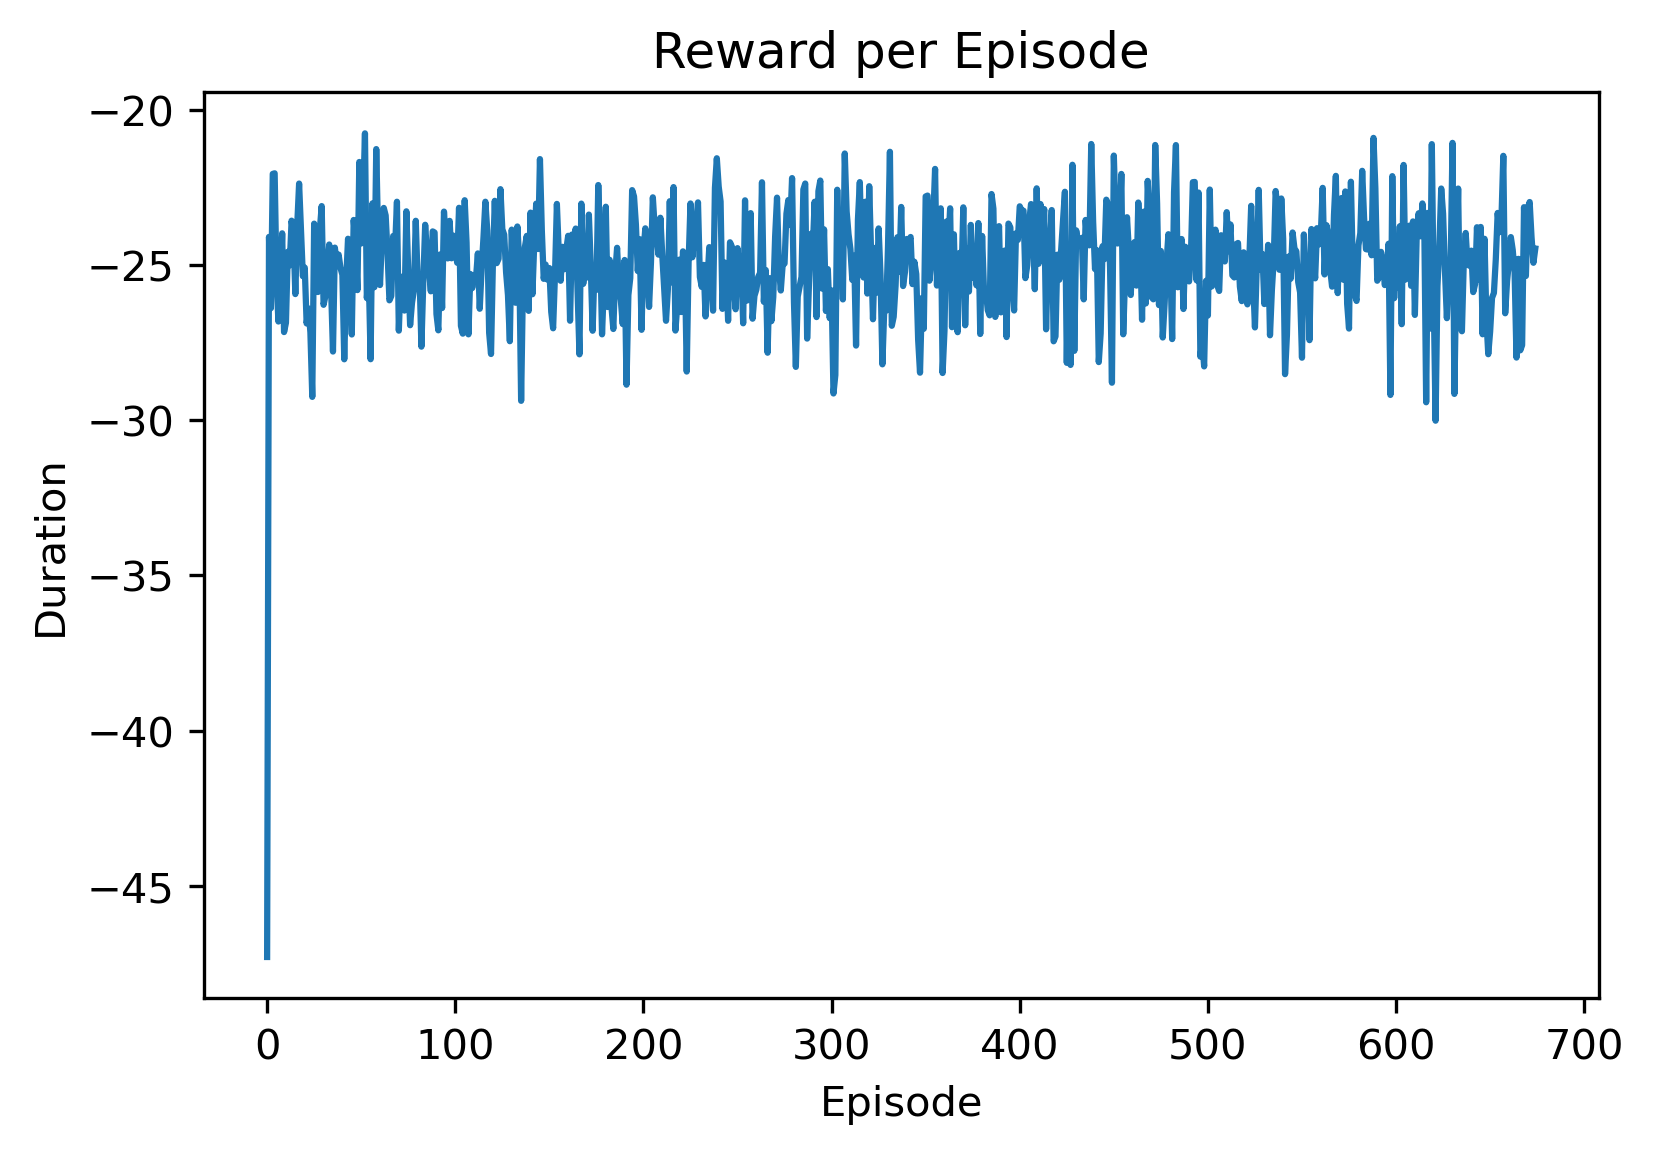

In [19]:
plot_reward(reward_values)

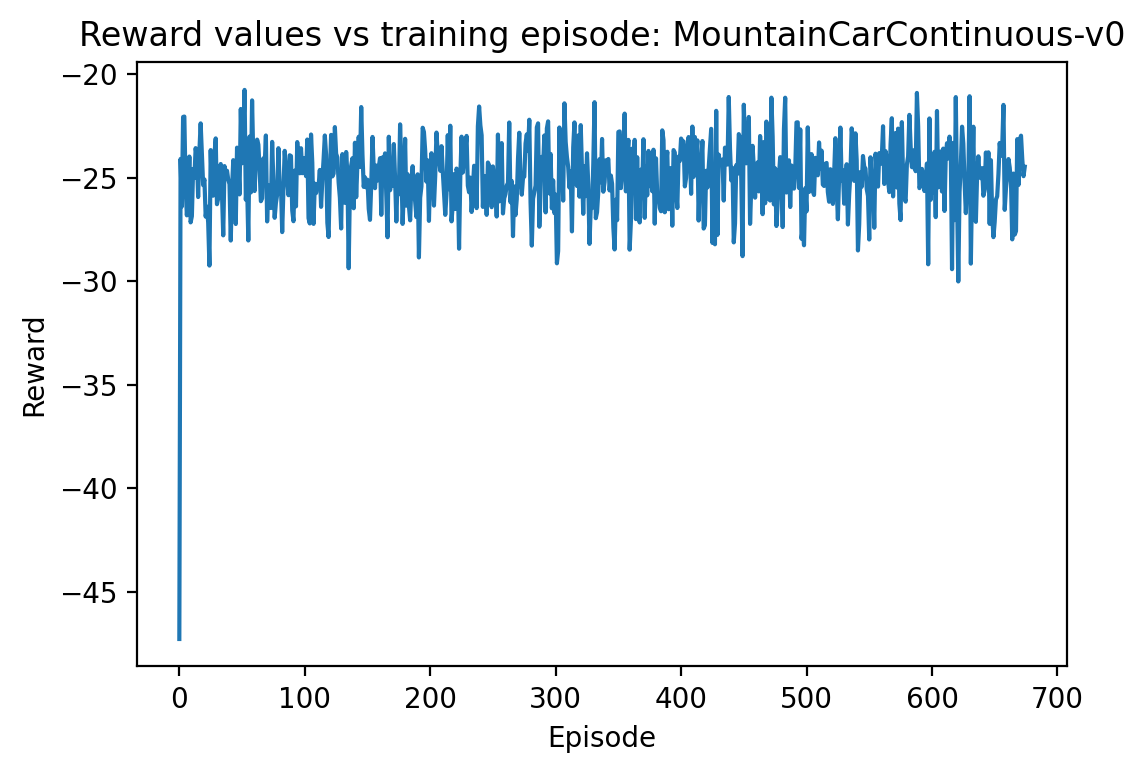

In [21]:
def save_reward(reward_values):
    '''Show the reward per episode on the yaxis..
    '''
    plt.figure(2,dpi=200) 
    #plt.clf()
    reward_values = torch.tensor(reward_values, dtype=torch.float)
    plt.title('Reward values vs training episode: MountainCarContinuous-v0')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(reward_values)
    plt.savefig('plots/MCC/RewardperEp.png')

save_reward(reward_values)

In [17]:
for i in range(len(memory)):
    print(memory.get_item(i).state)

tensor([[ 0.1913, -0.0005]])
tensor([[0.1955, 0.0530]])
tensor([[0.1981, 0.0333]])
tensor([[0.1984, 0.0030]])
tensor([[ 0.1965, -0.0240]])
tensor([[ 0.1951, -0.0188]])
tensor([[ 0.1894, -0.0729]])
tensor([[ 0.1789, -0.1342]])
tensor([[ 0.1648, -0.1802]])
tensor([[ 0.1579, -0.0877]])
tensor([[ 0.1481, -0.1253]])
tensor([[ 0.1457, -0.0312]])
tensor([[ 0.1395, -0.0796]])
tensor([[ 0.1268, -0.1628]])
tensor([[ 0.1189, -0.1007]])
tensor([[ 0.1127, -0.0791]])
tensor([[ 0.1074, -0.0684]])
tensor([[ 0.0986, -0.1131]])
tensor([[ 0.0851, -0.1725]])
tensor([[ 0.0623, -0.2898]])
tensor([[ 0.0341, -0.3603]])
tensor([[ 0.0088, -0.3226]])
tensor([[-0.0188, -0.3518]])
tensor([[-0.0398, -0.2684]])
tensor([[-0.0583, -0.2364]])
tensor([[-0.0806, -0.2837]])
tensor([[-0.1013, -0.2651]])
tensor([[-0.1258, -0.3124]])
tensor([[-0.1579, -0.4095]])
tensor([[-0.1932, -0.4501]])
tensor([[-0.2231, -0.3811]])
tensor([[-0.2568, -0.4296]])
tensor([[-0.2817, -0.3178]])
tensor([[-0.3005, -0.2396]])
tensor([[-0.3112, -0

tensor([[ 0.7795, -0.3459]])
tensor([[ 0.7410, -0.4914]])
tensor([[ 0.6916, -0.6297]])
tensor([[ 0.6327, -0.7506]])
tensor([[ 0.5691, -0.8106]])
tensor([[ 0.4940, -0.9570]])
tensor([[ 0.4214, -0.9250]])
tensor([[ 0.3542, -0.8568]])
tensor([[ 0.2760, -0.9970]])
tensor([[ 0.2007, -0.9593]])
tensor([[ 0.1173, -1.0635]])
tensor([[ 0.0244, -1.1838]])
tensor([[-0.0714, -1.2206]])
tensor([[-0.1602, -1.1314]])
tensor([[-0.2410, -1.0297]])
tensor([[-0.3260, -1.0830]])
tensor([[-0.4000, -0.9438]])
tensor([[-0.4757, -0.9647]])
tensor([[-0.5447, -0.8797]])
tensor([[-0.6012, -0.7201]])
tensor([[-0.6448, -0.5554]])
tensor([[-0.6922, -0.6042]])
tensor([[-0.7315, -0.5007]])
tensor([[-0.7679, -0.4648]])
tensor([[-0.7985, -0.3895]])
tensor([[-0.8246, -0.3333]])
tensor([[-0.8519, -0.3484]])
tensor([[-0.8788, -0.3432]])
tensor([[-0.9007, -0.2797]])
tensor([[-0.9090, -0.1052]])
tensor([[-0.9043,  0.0589]])
tensor([[-0.8923,  0.1528]])
tensor([[-0.8782,  0.1783]])
tensor([[-0.8626,  0.1981]])
tensor([[-0.84